In [1]:
# Data related variables, treatment, loading and visualization
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import math

# Just to time the training of the model
import time

# Pytorch libraries to create and train the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError

# Remove Warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_data(ticker: str, dates: list[str, str]) -> pd.DataFrame:
    """The dataset is delivered in USD, gets the data from the yahoo finance API

    Args:
        ticker (str): the ticker of stock, ETF or crypto (example.: apple->ticker:AAPL)
        dates (list[str, str]): list of two dates of str type, [start data, end date] (example.: ["2012-10-21", "2022-10-20"])

    Returns:
        pd.DataFrame: returns the dataset as dataframe
    """
    # API call to get the data as a dataframe
    panel_data = data.DataReader(ticker, "yahoo", dates[0], dates[1])

    # Resample the data to normalize it, the data comes without any data on the (days that the markets are close, weekends)
    panel_data = panel_data.resample("D").max()

    # Fill the data in the closed markets with the data from the previous trading day, because it is their true value
    panel_data = panel_data.fillna(method="ffill")

    print(f"\n{ticker} data acquired")

    return panel_data

In [ ]:
# Get the data for S&P500 ticker ^GSPC 
ticker = "^GSPC"

source_df = get_data(ticker=ticker, dates=["2000-01-01", "2022-12-1"])
source_df = source_df.reset_index()
source_df.tail()


^GSPC data acquired


,Date,High,Low,Open,Close,Volume,Adj Close
8364,2022-11-27,4034.020020,4020.760010,4023.340088,4026.120117,1.706460e+09,4026.120117
8365,2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3.615430e+09,3963.939941
8366,2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3.546040e+09,3957.629883
8367,2022-11-30,4080.110107,3938.580078,3957.179932,4080.110107,6.579360e+09,4080.110107
8368,2022-12-01,4100.509766,4050.870117,4087.139893,4076.570068,4.527130e+09,4076.570068


In [ ]:
def two_plots(ticker: str, df: pd.DataFrame) -> None:
    """Generates the plot to show the prices and Volume of the stock

    Args:
        ticker (str): the trading stock
        df (pd.DataFrame): the dataframe with the data of the stock
    """
    fig = plt.figure(figsize=(15,10))
    st = fig.suptitle(f"{ticker} Close Price")
    st.set_y(0.92)

    ax1 = fig.add_subplot(211)
    ax1.plot(df['Date'],df['Close'], label=f'{ticker} Close Price')
    ax1.set_ylabel('Close Price', fontsize=18)
    ax1.legend(loc="upper left", fontsize=12)
    ax1.grid(linestyle="--")

    ax2 = fig.add_subplot(212)
    ax2.plot(df["Date"],df['Volume'], label=f'{ticker} Volume')
    ax2.set_ylabel('Volume', fontsize=18)
    ax2.legend(loc="upper left", fontsize=12)
    ax2.grid(linestyle="--")

# Main parameters to feed the model
Sequence length -> 128 days\
Batch size -> 32 sequences per batch

With the 128 days we'll predict the following day


Since we have 5 features, this will result in batches of size (32, 128, 5):
* Price Columns (4 features):
    * Open
    * High
    * Low
    * Close
* Volume Columns (1 feature):
    * Volume

In [ ]:
# the features are separated into sequences of 128 days, 4 price features and 1 volume feature
seq_len = 128

# during a single step the model receives 32 sequences
batch_size = 32

In [ ]:
# Selection of columns
df = source_df[["Date", "High", "Low", "Open", "Close", "Volume"]].copy(deep=True)

# Avoid dividing by 0 
# (The volume isn't a given, for really old data we can have values of 0 for the volume)
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)

# Sort the values based on date
df.sort_values('Date', inplace=True)

df.tail()

,Date,High,Low,Open,Close,Volume
8364,2022-11-27,4034.020020,4020.760010,4023.340088,4026.120117,1.706460e+09
8365,2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3.615430e+09
8366,2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3.546040e+09
8367,2022-11-30,4080.110107,3938.580078,3957.179932,4080.110107,6.579360e+09
8368,2022-12-01,4100.509766,4050.870117,4087.139893,4076.570068,4.527130e+09


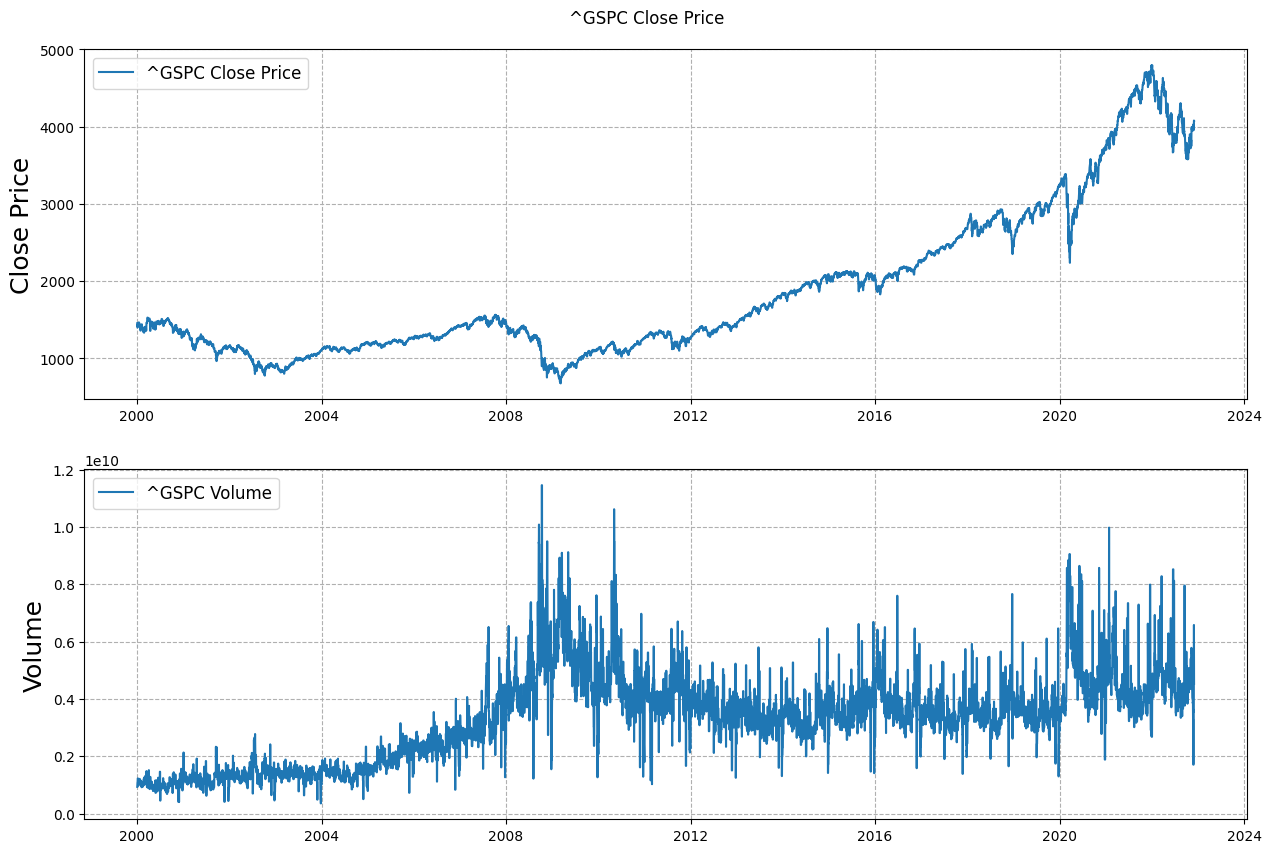

In [ ]:
two_plots(ticker=ticker, df=df)

## Data normalization 
- Instead of the values we keep the percentage of change
- Get the separation index values
- Get the min and max returns
- Normalize the data with the max and min (0-1 range)

In [ ]:
def data_normalization(df: pd.DataFrame) -> tuple[pd.DataFrame, np.int64, np.int64]:
    """normalizes the data

    Args:
        df (pd.DataFrame): data

    Returns:
        tuple[pd.DataFrame, np.int64, np.int64]: dataframe, last 10 percent, last 20 percent
    """
    # Create arithmetic returns column
    df['Open'] = df['Open'].pct_change() 
    df['High'] = df['High'].pct_change()
    df['Low'] = df['Low'].pct_change()
    df['Close'] = df['Close'].pct_change()
    df['Volume'] = df['Volume'].pct_change()

    # Drop the rows with the NaN created by the percentage change
    df.dropna(how="any", axis=0, inplace=True)

    # Get the values to create the separation of the dataset
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))]
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))]

    # min-max price columns
    min_return = min(df[(df.index<last_20pct)][["Open", "High", "Low", "Close"]].min(axis=0))
    max_return = max(df[(df.index<last_20pct)][["Open", "High", "Low", "Close"]].max(axis=0))

    # Min-max normalize price columns (0-1 range)
    df["Open"] = (df["Open"] - min_return) / (max_return - min_return)
    df["High"] = (df["High"] - min_return) / (max_return - min_return)
    df["Low"] = (df["Low"] - min_return) / (max_return - min_return)
    df["Close"] = (df["Close"] - min_return) / (max_return - min_return)

    # min-max volume column
    min_volume = df[(df.index<last_20pct)]["Volume"].min(axis=0)
    max_volume = df[(df.index<last_20pct)]["Volume"].max(axis=0)

    # Min-max normalize volume columns (0-1 range)
    df["Volume"] = (df["Volume"] - min_volume) / (max_volume - min_volume)

    return df, last_10pct, last_20pct
    

In [ ]:
df, last_10pct, last_20pct = data_normalization(df=df)

## Split the data 
- Split into train, the first 80% of the data
- Split into validation, between the first 80% and 90% of the data
- Split into test, between 90% and tha 100% of the data

In [ ]:
def split_data(df: pd.DataFrame, last_20pct: np.int64, last_10pct: np.int64) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Splits the data into train, validation and test

    Args:
        df (pd.DataFrame): data to split
        last_20pct (np.int64): the position to split on the 80%
        last_10pct (np.int64): the position to split on the 90%

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: train data, validation data and test data
    """
    df_train = df[(df.index < last_20pct)]
    df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    df_test = df[(df.index >= last_10pct)]

    # Drop the date column from the splitted datasets
    df_train.drop(columns=["Date"], inplace=True)
    df_val.drop(columns=["Date"], inplace=True)
    df_test.drop(columns=["Date"], inplace=True)

    # Train data into arrays np.ndarray
    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values

    print('Training data shape: {}'.format(train_data.shape))
    print('Validation data shape: {}'.format(val_data.shape))
    print('Test data shape: {}'.format(test_data.shape))

    print(df_train.head(10))

    return (train_data, val_data, test_data)

In [ ]:
train_data, val_data, test_data = split_data(df=df, last_10pct=last_10pct, last_20pct=last_20pct)

Training data shape: (6695, 5)
Validation data shape: (837, 5)
Test data shape: (836, 5)
        High       Low      Open     Close    Volume
1   0.363507  0.300237  0.391951  0.252268  0.211225
2   0.298436  0.369714  0.252268  0.447596  0.209465
3   0.433569  0.489044  0.447596  0.442908  0.192058
4   0.539865  0.468343  0.442908  0.569683  0.220940
5   0.438272  0.438272  0.438272  0.438272  0.190491
6   0.438272  0.438272  0.438272  0.438272  0.190491
7   0.515301  0.579357  0.569683  0.492552  0.157727
8   0.419390  0.414547  0.492552  0.374908  0.178551
9   0.384863  0.413449  0.374908  0.416994  0.180766
10  0.477277  0.455845  0.416994  0.497305  0.204819


# Visualization of the data separated

In [ ]:
def data_separated_plot(train_data: np.ndarray, val_data: np.ndarray, test_data: np.ndarray):
    """Visualize the data splitted

    Args:
        train_data (np.ndarray): training data
        val_data (np.ndarray): validation data
        test_data (np.ndarray): testing data
    """
    fig = plt.figure(figsize=(15, 10))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)

    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(train_data.shape[0]), train_data[:,3], label='Training data')
    ax1.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), val_data[:,3], label='Validation data')
    ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:,3], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Closing Returns')
    ax1.set_title("Close Price", fontsize=18)
    ax1.legend(loc="best", fontsize=12)
    ax1.grid()

    ax2 = fig.add_subplot(212)
    ax2.plot(np.arange(train_data.shape[0]), train_data[:,4], label='Training data')
    ax2.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), val_data[:,4], label='Validation data')
    ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:,4], label='Test data')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Normalized Volume Changes')
    ax2.set_title("Volume", fontsize=18)
    ax2.legend(loc="best", fontsize=12)
    ax2.grid()

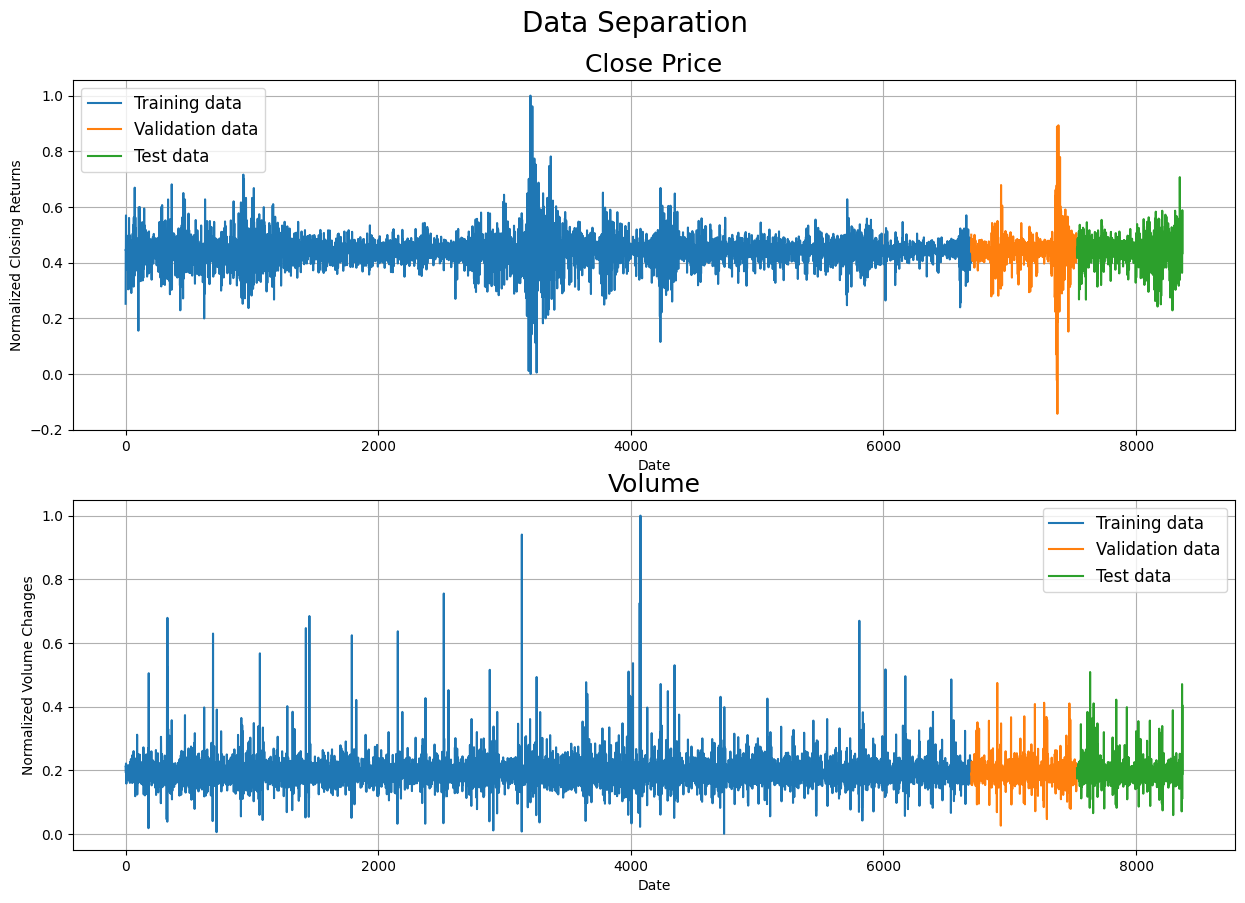

In [ ]:
data_separated_plot(train_data=train_data, val_data=val_data, test_data=test_data)

# Dataset
Creation of dataset class which will have the definition of the targets and inputs

In [ ]:
class TickerData(Dataset):
    """Dataset class to create the dataset (inputs & targets) for train, validation and test

    Args:
        Dataset (_type_): imported from torch.utils.data
    """
    def __init__(self, data: np.ndarray, seq_len: int) -> None:
        """Init function of dataset class

        Args:
            data (np.ndarray): data from the dataframe to numpy
            seq_len (int): len of values to base for the prediction
        """
        self.inputs, self.targets = [], []

        for i in range(seq_len, len(data)):
            # Chunks of  data with a length of 128 df-rows
            self.inputs.append(data[i-seq_len:i])
            
            # Value of 4th column (Close Price) of df-row 128+1
            self.targets.append(data[:, 3][i])
        
        self.inputs, self.targets = torch.FloatTensor(np.array(self.inputs)), torch.FloatTensor(np.array(self.targets))
        
    def __getitem__(self, idx: int) -> dict:
        """Get item at a certain index

        Args:
            idx (int): index to get the value

        Returns:
            dict: returns the input and the target
        """
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}
    
    def __len__(self) -> int:
        """Length function 

        Returns:
            int: length of the Dataset
        """
        return min(len(self.inputs), len(self.targets))

In [ ]:
train_data = TickerData(data=train_data, seq_len=seq_len)
val_data = TickerData(data=val_data, seq_len=seq_len)
test_data = TickerData(data=test_data, seq_len=seq_len)

# Data Loader 
Data loading, creation of the batches to feed the model

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

# Device
For some unknown reason it's faster on CPU however I leave commented the possibility of running on mps

In [ ]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Model Creation -> Transformer
Creation of the time to vector class for the positional encoding\
Creation of the transformer model 

## Time2Vector

In [ ]:
class Time2Vector(nn.Module):
    """Time to vector encoding to keep the position of the values as a feature

    Args:
        nn (_type_): imported from torch 
    """
    def __init__(self, seq_len):
        """init function

        Args:
            seq_len (_type_): sequence length 
        """
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.weights_linear)

        self.bias_linear = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.bias_linear)

        self.weights_periodic = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.weights_periodic)

        self.bias_periodic = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.bias_periodic)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """forward function that gets called when to do the time2vec

        Args:
            x (torch.Tensor): input data

        Returns:
            torch.Tensor: tensor that gives the periodic and the linear features
        """
        x = torch.mean(x[:,:,:4], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

## Transformer

In [ ]:
class TimeSeriesTransformer(nn.Module):
    """Transformer model

    Args:
        nn (_type_): module from torch
    """
    def __init__(self,feature_size: int=128, num_layers: int=1, dropout: float=0.0):
        """initiation function that creates the layers

        Args:
            feature_size (int, optional): size of the feature (sequence length). Defaults to 128.
            num_layers (int, optional): number of layers. Defaults to 1.
            dropout (float, optional): dropout. Defaults to 0.0.
        """
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.t2v = Time2Vector(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)     
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        """weights initialization
        """
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src: torch.Tensor) -> torch.Tensor:
        
        # Generation of the mask
        if self.src_mask is None or self.src_mask.size(0) != 7:
            device = src.device
            mask = self._generate_square_subsequent_mask(7).to(device)
            self.src_mask = mask

        # first goes through time to vector layer for the position features
        t2v = self.t2v(src)
        # adds the 2 features that derived from the time to the five original features (open, high, low, close, volume)
        src = torch.concatenate((t2v, src), axis=2)
        # encoder layer
        output = self.transformer_encoder(src.swapaxes(1,2), self.src_mask)
        # decoder layer 
        output = self.decoder(output[:, -1, :])

        return output

    def _generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """generates the mask to eliminate the information from the future

        Args:
            sz (int): size of the mask, number of features, in the present case it is 7

        Returns:
            torch.Tensor: mask
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        
        return mask

In [ ]:
# model attribution
model = TimeSeriesTransformer().to(device)

# The criterion is the MSE (Mean Squared Error)
criterion = nn.MSELoss()

# ADAM as optimizer
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1.0, gamma=0.98)

# Metrics for evaluation of the model
mean_absolute_error = MeanAbsoluteError()
mean_absolute_percentage_error = MeanAbsolutePercentageError()

# Training

In [ ]:
def train_model(model, prev_loss: torch.Tensor, train_loader: DataLoader, epoch: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """function to train the model, gets the batch and trains on the batch

    Args:
        train_loader (DataLoader): data to train on
        prev_loss (torch.Tensor): previous loss to save the model on the best loss

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: returns the loss, mae and mape
    """
    # Turn on the train mode
    model.train()

    total_loss = 0.
    start_time = time.time()

    total_mae = 0.
    total_mape = 0.

    for i, batch in enumerate(train_loader):
        
        # data from batch and to device
        data, targets = batch['inputs'].to(device), batch['targets'].to(device).unsqueeze(1)

        optimizer.zero_grad()

        output = model(data)  

        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_loader) / 5)

        mae = mean_absolute_error(output, targets)
        mape = mean_absolute_percentage_error(output, targets)

        if i % log_interval == 0 and i > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time

            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f} | '
                  'mae {:5.5f} | mape {:5.5}'.format(
                    epoch, i, len(train_loader), scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss),
                    mae.item(), mape.item()))

            total_loss = 0
            start_time = time.time()

        total_mae += mae
        total_mape += mape
            
        if loss < prev_loss:
            
            torch.save(model.state_dict(), 'tranformer_models/state_dict.pt')  # save model state (wights, etc.)
            torch.save(model, 'tranformer_models/model_complete.pt')  # save complete model
            
            prev_loss = loss

    return prev_loss, total_mae / len(train_loader), total_mape / len(train_loader)

In [ ]:
def evaluate(eval_model, val_loader: DataLoader):
    """evaluation function

    Args:
        eval_model (_type_): model
        val_loader (DataLoader): data from dataloader

    Returns:
        _type_: loss, mae, mape
    """
    
    # Turn on the evaluation mode
    eval_model.eval()

    total_loss = 0.

    total_mae = 0.
    total_mape = 0.
    
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            # print(batch["targets"])
            data, targets = batch['inputs'].to(device), batch["targets"].to(device).unsqueeze(1)
            
            # print(data.size())
            output = eval_model(data)
            total_mae += mean_absolute_error(output, targets)
            total_mape += mean_absolute_percentage_error(output, targets)

            total_loss += len(data[0])* criterion(output[-1:], targets[-1:]).cpu().item()

    return total_loss / len(val_loader), total_mae / len(val_loader), total_mape / len(val_loader)

In [ ]:
def fit(epochs: int, model, train_loader: DataLoader, val_loader: DataLoader) -> tuple[list, list, list, list]:

    # Initialization of the prev loss as Inf to make sure thar the model starts saving
    prev_loss = np.Inf

    # Matrices to store the evaluation metrics
    train_mae = []
    train_mape = []

    val_mae = []
    val_mape = []

    for epoch in range(1, epochs + 1):

        epoch_start_time = time.time()
        prev_loss, mae_train, mape_train = train_model(model=model, prev_loss=prev_loss, epoch=epoch, train_loader=train_loader)
        
        train_mae.append(mae_train.cpu().detach().numpy())
        train_mape.append(mape_train.cpu().detach().numpy())
        
        val_loss, mae_val, mape_val = evaluate(eval_model=model, val_loader=val_loader)

        val_mae.append(mae_val.cpu().detach().numpy())
        val_mape.append(mape_val.cpu().detach().numpy())
            
        print('-' * 118)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f} | valid MAE {:5.5f} | valid MAPE {:5.5f}'.format(epoch, (time.time() - epoch_start_time),
                                        val_loss, math.exp(val_loss), mae_val, mape_val))
        print('-' * 118)

        scheduler.step()

    return train_mae, train_mape, val_mae, val_mape 

In [ ]:
train_mae, train_mape, val_mae, val_mape = fit(epochs=1000, model=model, train_loader=train_loader, val_loader=val_loader)

| epoch   1 |    41/  205 batches | lr 0.005000 | 13.63 ms | loss 1.63919 | ppl     5.15 | mae 0.18038 | mape 0.40281
| epoch   1 |    82/  205 batches | lr 0.005000 | 11.05 ms | loss 0.00720 | ppl     1.01 | mae 0.05906 | mape 0.13842
| epoch   1 |   123/  205 batches | lr 0.005000 | 10.10 ms | loss 0.00599 | ppl     1.01 | mae 0.05105 | mape 0.12757
| epoch   1 |   164/  205 batches | lr 0.005000 | 10.22 ms | loss 0.00196 | ppl     1.00 | mae 0.04059 | mape 0.092359
----------------------------------------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.37s | valid loss 1.04989 | valid ppl     2.86 | valid MAE 0.03297 | valid MAPE 0.11685
----------------------------------------------------------------------------------------------------------------------
| epoch   2 |    41/  205 batches | lr 0.004802 | 11.25 ms | loss 0.00337 | ppl     1.00 | mae 0.02088 | mape 0.045443
| epoch   2 |    82/  205 batches | lr 0.004802 |  9.

# Evaluate the model

In [ ]:
# load the bets model
model.load_state_dict(torch.load('tranformer_models/state_dict.pt'))

<All keys matched successfully>

In [ ]:
model

TimeSeriesTransformer(
  (t2v): Time2Vector()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(

## Mean Absolute Error and Mean Absolute Percentage Error evaluations 

In [ ]:
def evaluation_plots(train_mae: list, val_mae: list, train_mape: list, val_mape: list) -> None:
    """plots the mae and mape

    Args:
        train_mae (list): train mae list
        val_mae (list): val mae list
        train_mape (list): train mape list 
        val_mape (list): val mape list
    """
    fig = plt.figure(figsize=(15, 10))
    st = fig.suptitle("MAE and MAPE Evaluation", fontsize=20)
    st.set_y(0.95)

    ax1 = fig.add_subplot(211)
    ax1.plot(train_mae, label='training MAE')
    ax1.plot(val_mae, label='validation MAE')
    ax1.set_xlabel('Epochs')
    ax1.set_title("MAE", fontsize=18)
    ax1.legend(loc="best", fontsize=12)
    ax1.grid(linestyle="--")

    ax2 = fig.add_subplot(212)
    ax2.plot(train_mape, label='training MAPE')
    ax2.plot(val_mape, label='validation MAPE')
    ax2.set_xlabel('Epochs')
    ax2.set_title("MAPE", fontsize=18)
    ax2.legend(loc="best", fontsize=12)
    ax2.grid(linestyle="--")

    print(f"Train -> MAE: {train_mae[-1]} | MAPE: {train_mape[-1]}")
    print(f"Validation -> MAE: {val_mae[-1]} | MAPE: {val_mape[-1]}")

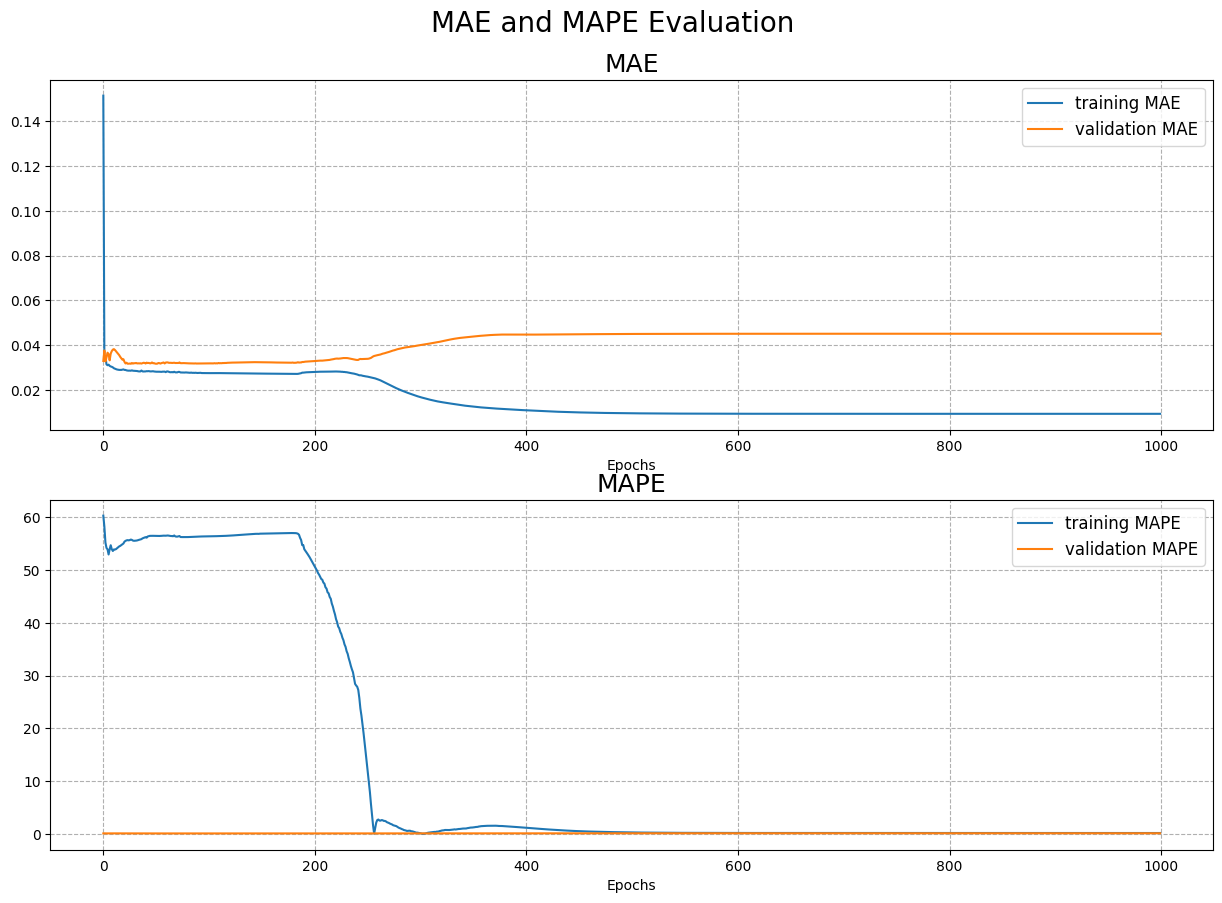

In [ ]:
evaluation_plots(train_mae=train_mae, train_mape=train_mape, val_mae=val_mae, val_mape=val_mape)

## Predictions evaluation

In [ ]:
def test_predictions(model, test_loader: DataLoader) -> list:
    test_losses = []
    test_preds = []

    model.eval()

    for batch in test_loader:
        
        inputs, labels = batch['inputs'].to(device), batch['targets'].to(device).unsqueeze(1)

        output = model(inputs)

        test_preds.append(output.cpu().detach().numpy())

        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
            
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    return test_preds

In [ ]:
test_preds = test_predictions(model=model, test_loader=test_loader)

Test loss: 0.003


In [ ]:
def plot_predictions(test_preds: list, test_loader: DataLoader) -> None:
    """predictions plot 

    Args:
        test_preds (list): predictions 
        test_loader (DataLoader): loader from ther real dataset
    """
    plt.figure(figsize=(15, 10))
    plt.plot(np.concatenate(test_preds, axis=0), label='Prediction')
    plt.plot(test_loader.dataset[:]["targets"], label= 'Real', alpha =0.5)
    plt.legend(loc="best", fontsize=12)
    plt.grid(linestyle="--")

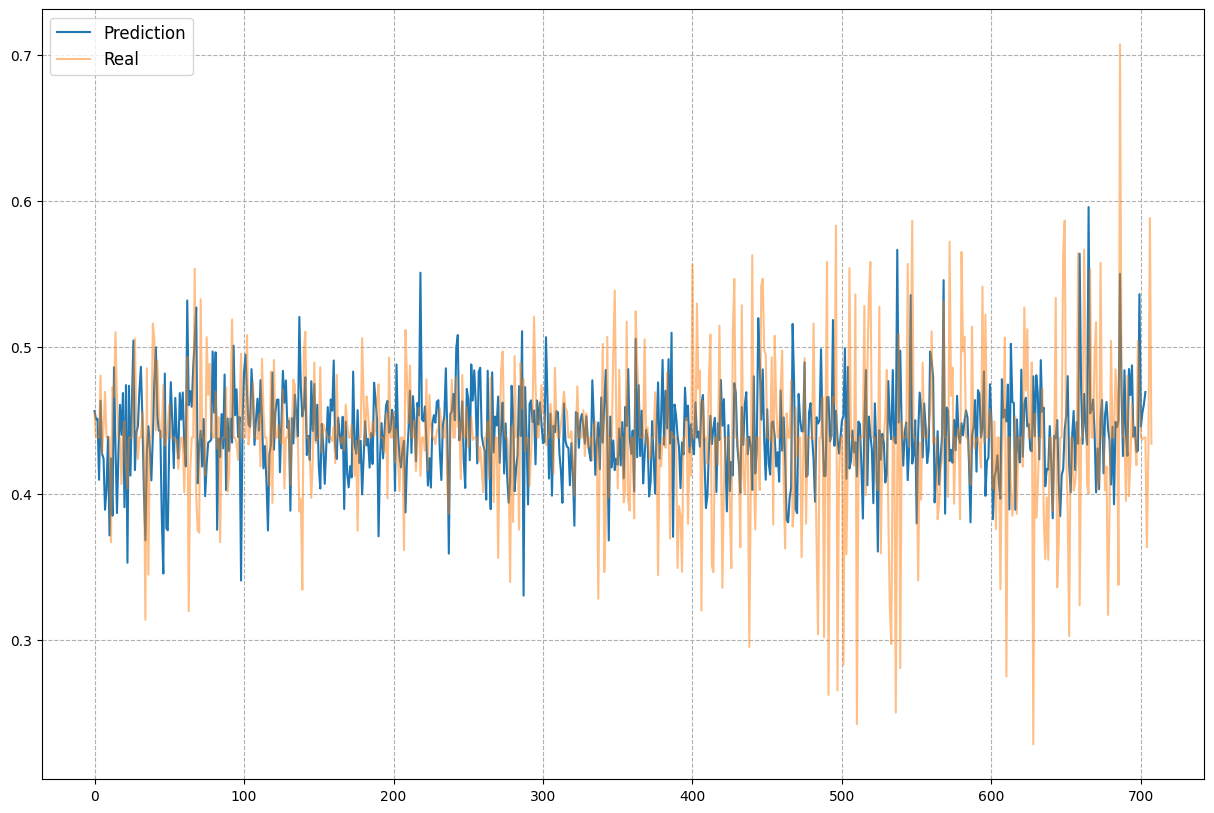

In [ ]:
plot_predictions(test_preds=test_preds, test_loader=test_loader)

# Data with moving average

Since the results from the data presented above aren't that good, we can use the moving average that is already known in the stocks industry

In [ ]:
# test the original data 
source_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
8364,2022-11-27,4034.020020,4020.760010,4023.340088,4026.120117,1.706460e+09,4026.120117
8365,2022-11-28,4012.270020,3955.770020,4005.360107,3963.939941,3.615430e+09,3963.939941
8366,2022-11-29,3976.770020,3937.649902,3964.189941,3957.629883,3.546040e+09,3957.629883
8367,2022-11-30,4080.110107,3938.580078,3957.179932,4080.110107,6.579360e+09,4080.110107
8368,2022-12-01,4100.509766,4050.870117,4087.139893,4076.570068,4.527130e+09,4076.570068


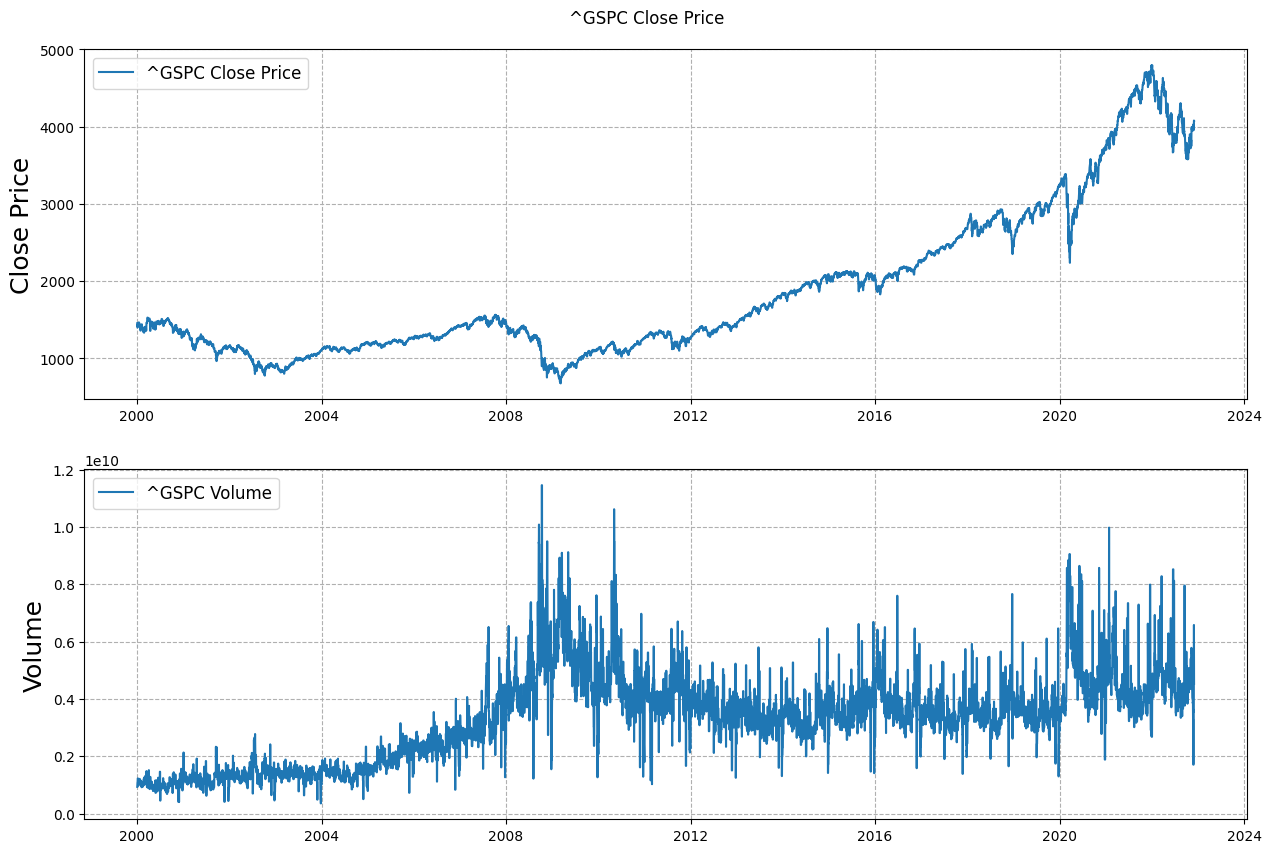

In [ ]:
two_plots(ticker=ticker, df=source_df)

In [ ]:
# Selection of columns
df = source_df[["Date", "High", "Low", "Open", "Close", "Volume"]].copy(deep=True)

# Avoid dividing by 0 
# (The volume isn't a given, for really old data we can have values of 0 for the volume)
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)

# Sort the values based on date
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()

df.tail()

,Date,High,Low,Open,Close,Volume
8364,2022-11-27,4007.716968,3975.775977,3989.153003,3998.242065,3.152958e+09
8365,2022-11-28,4010.954980,3977.754980,3993.050024,3998.102051,3.110765e+09
8366,2022-11-29,4010.642993,3977.921973,3992.830029,3997.331030,3.061633e+09
8367,2022-11-30,4020.665015,3978.181982,3991.909033,4008.808032,3.315833e+09
8368,2022-12-01,4034.515991,3989.934985,4005.000024,4021.471045,3.383477e+09


## Data normalization 
- Instead of the values we keep the percentage of change
- Get the separation index values
- Get the min and max returns
- Normalize the data with the max and min (0-1 range)

In [ ]:
df, last_10pct, last_20pct = data_normalization(df=df)

## Split the data 
- Split into train, the first 80% of the data
- Split into validation, between the first 80% and 90% of the data
- Split into test, between 90% and tha 100% of the data

In [ ]:
train_data, val_data, test_data = split_data(df=df, last_10pct=last_10pct, last_20pct=last_20pct)

Training data shape: (6688, 5)
Validation data shape: (836, 5)
Test data shape: (835, 5)
        High       Low      Open     Close    Volume
10  0.596522  0.622713  0.576142  0.623704  0.521471
11  0.658639  0.711954  0.623659  0.731143  0.514876
12  0.721256  0.741750  0.708226  0.726653  0.492547
13  0.722927  0.719336  0.703895  0.724238  0.490576
14  0.678750  0.705955  0.701640  0.667282  0.452035
15  0.667048  0.708140  0.724627  0.652356  0.442942
16  0.661444  0.703944  0.709277  0.653465  0.451441
17  0.634041  0.627674  0.653534  0.614218  0.503280
18  0.623978  0.639794  0.614161  0.636206  0.551402
19  0.647646  0.650758  0.642486  0.645566  0.561985


# Visualization of the data separated

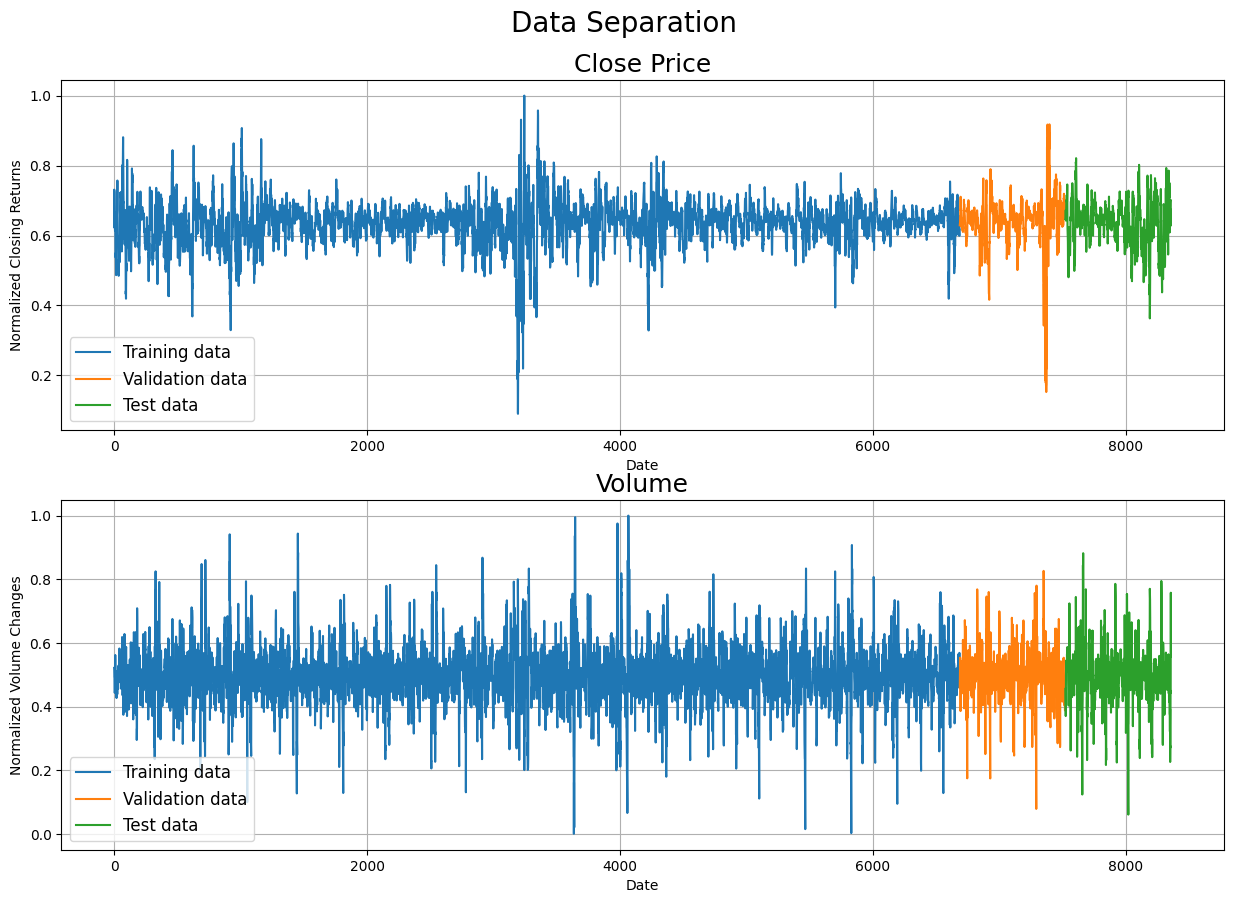

In [ ]:
data_separated_plot(train_data=train_data, val_data=val_data, test_data=test_data)

# Dataset

In [ ]:
train_data = TickerData(data=train_data, seq_len=seq_len)
val_data = TickerData(data=val_data, seq_len=seq_len)
test_data = TickerData(data=test_data, seq_len=seq_len)

# Data Loader 
Data loading, creation of the batches to feed the model

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

# Device
For some unknown reason it's faster on CPU however I leave commented the possibility of running on mps

In [ ]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [ ]:
# model attribution
model = TimeSeriesTransformer().to(device)

# The criterion is the MSE (Mean Squared Error)
criterion = nn.MSELoss()

# ADAM as optimizer
lr = 0.005
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1.0, gamma=0.98)

# Metrics for evaluation of the model
mean_absolute_error = MeanAbsoluteError()
mean_absolute_percentage_error = MeanAbsolutePercentageError()

In [ ]:
train_mae, train_mape, val_mae, val_mape = fit(epochs=1000, model=model, train_loader=train_loader, val_loader=val_loader)

| epoch   1 |    41/  205 batches | lr 0.005000 | 11.72 ms | loss 1.40934 | ppl     4.09 | mae 0.25920 | mape 0.38833
| epoch   1 |    82/  205 batches | lr 0.005000 | 11.51 ms | loss 0.01746 | ppl     1.02 | mae 0.11435 | mape 0.20439
| epoch   1 |   123/  205 batches | lr 0.005000 | 10.94 ms | loss 0.01002 | ppl     1.01 | mae 0.04193 | mape 0.068349
| epoch   1 |   164/  205 batches | lr 0.005000 |  9.47 ms | loss 0.00533 | ppl     1.01 | mae 0.06880 | mape 0.10359
----------------------------------------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.24s | valid loss 1.69190 | valid ppl     5.43 | valid MAE 0.11288 | valid MAPE 0.18391
----------------------------------------------------------------------------------------------------------------------
| epoch   2 |    41/  205 batches | lr 0.004802 |  9.72 ms | loss 0.01093 | ppl     1.01 | mae 0.02430 | mape 0.036125
| epoch   2 |    82/  205 batches | lr 0.004802 |  9.

# Evaluate the model

In [ ]:
# load the bets model
model.load_state_dict(torch.load('tranformer_models/state_dict.pt'))

<All keys matched successfully>

In [ ]:
model

TimeSeriesTransformer(
  (t2v): Time2Vector()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(

## Mean Absolute Error and Mean Absolute Percentage Error evaluations 

Train -> MAE: 0.01880626194179058 | MAPE: 0.031072482466697693
Validation -> MAE: 0.0245609600096941 | MAPE: 0.04544047638773918


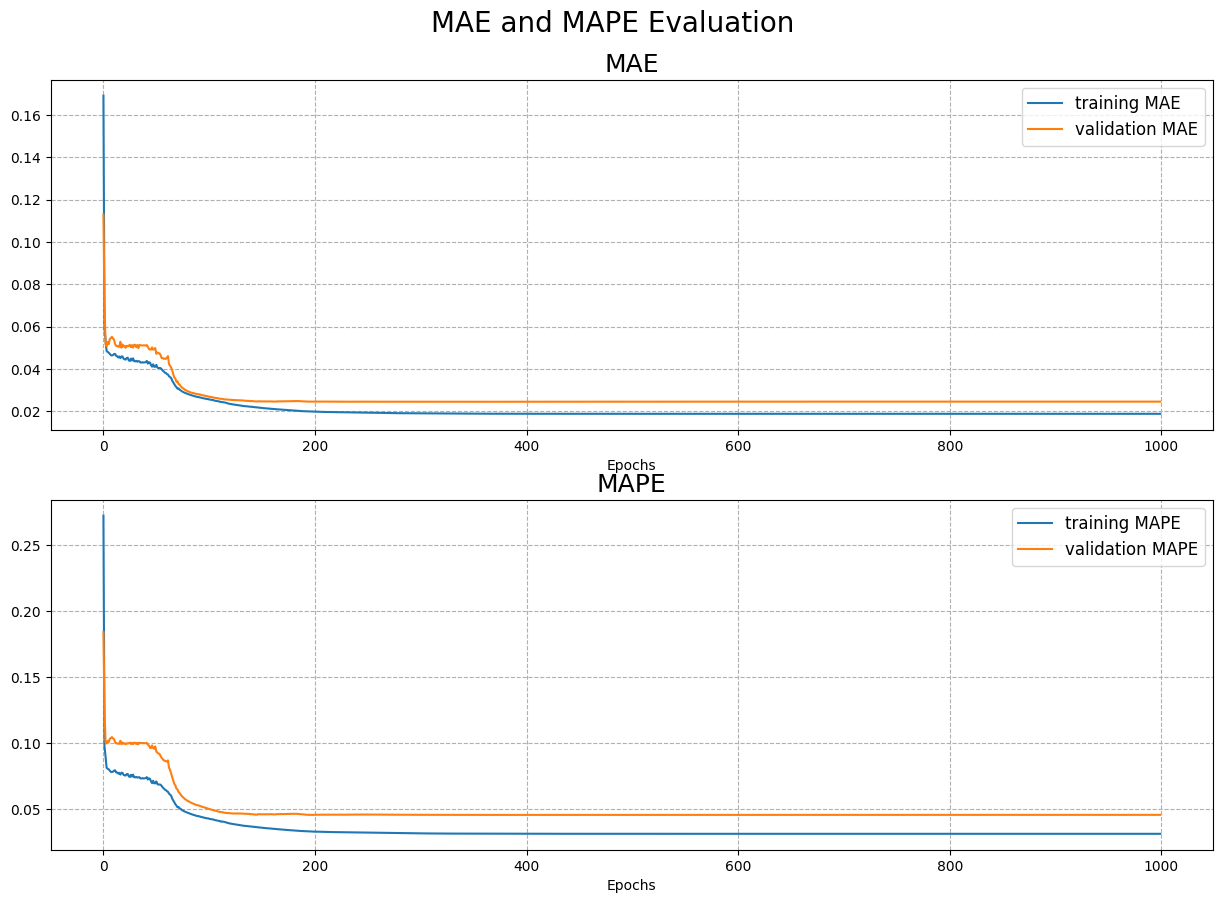

In [ ]:
evaluation_plots(
    train_mae=train_mae, train_mape=train_mape, 
    val_mae=val_mae, val_mape=val_mape
)

## Predictions evaluation

In [ ]:
test_preds = test_predictions(model=model, test_loader=test_loader)

Test loss: 0.006


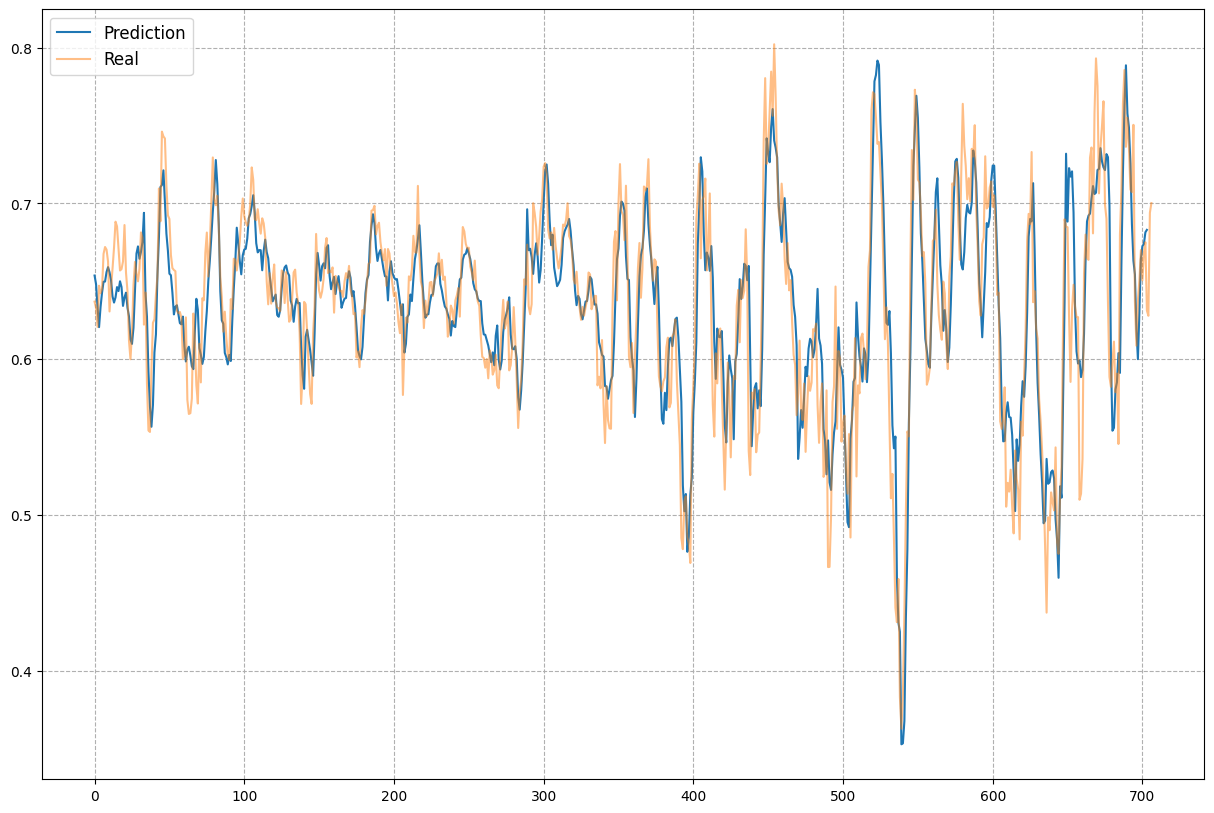

In [ ]:
plot_predictions(test_preds=test_preds, test_loader=test_loader)